In [ ]:
import sys
import mysql.connector
import xlsxwriter
import pandas as pd
import sys
import mysql.connector
import os
from dotenv import load_dotenv
load_dotenv()
#ESTE ARGUMENTO NO SE USA EN ESTE REPORTE, SERÁ 0 SIEMPRE UWU
id=str(sys.argv[1])
#configurar la conexion a la base de datos
DB_USERNAME = os.getenv('DB_USERNAME')
DB_DATABASE = os.getenv('DB_DATABASE')
DB_PASSWORD = os.getenv('DB_PASSWORD')
DB_PORT = os.getenv('DB_PORT')
a_color='#354F84'
b_color='#91959E'
# Conectar a DB
cnx = mysql.connector.connect(user=DB_USERNAME,
                              password=DB_PASSWORD,
                              host='localhost',
                              port=DB_PORT,
                              database=DB_DATABASE,
                              use_pure=False)
#Seccion para traer informacion de la base
query = ('SELECT * from customers where id = 1')

# join para cobros
# cobros=pd.read_sql('Select cobros.* ,customers.customer,internal_orders.invoice, users.name from ((cobros inner join internal_orders on internal_orders.id = cobros.order_id) inner join customers on customers.id = internal_orders.customer_id )inner join users on cobros.capturo=users.id',cnx)


#traer datos de los pedidos
pedidos=pd.read_sql("""Select internal_orders.* ,customers.clave,customers.alias,
coins.exchange_sell, coins.coin, coins.symbol, coins.code
from ((
    internal_orders
    inner join customers on customers.id = internal_orders.customer_id )
    inner join coins on internal_orders.coin_id = coins.id) 
     """,cnx)
cobros=pd.read_sql("""select cobro_orders.*
                     from (((
                         cobro_orders 
    inner join cobros on cobros.id=cobro_orders.cobro_id)
    inner join internal_orders on internal_orders.id = cobros.order_id )
    inner join coins on internal_orders.coin_id = coins.id) """,cnx)
facturas=pd.read_sql("""select * 
                     from ((
                         factures
    inner join internal_orders on internal_orders.id = factures.order_id )
    inner join coins on internal_orders.coin_id = coins.id) """,cnx)
creditos=pd.read_sql("""select * 
                     from ((
                         credit_notes    inner join internal_orders on internal_orders.id = credit_notes.order_id )
    inner join coins on internal_orders.coin_id = coins.id) """,cnx)
marcas=pd.read_sql("""select * 
                     from marcas""",cnx)
objetivo=pd.read_sql("""select * 
                     from settings""",cnx)['objetivo_monto'].values[0]

print(cobros)
nordenes=len(pedidos)
df=pedidos[['date']]

tc=pd.read_sql('select * from coins where id=13 ',cnx)['exchange_sell'].values[0]
writer = pd.ExcelWriter('storage/report/fab_por_monto1.xlsx', engine='xlsxwriter')
workbook = writer.book
##FORMATOS PARA EL TITULO------------------------------------------------------------------------------
rojo_l = workbook.add_format({
    'bold': 0,
    'border': 0,
    'align': 'center',
    'valign': 'vcenter',
    #'fg_color': 'yellow',
    'font_color': 'red',
    'font_size':16})
negro_s = workbook.add_format({
    'bold': 0,
    'border': 0,
    'align': 'center',
    'valign': 'vcenter',
    'font_color': 'black',
    'font_size':12})
negro_b = workbook.add_format({
    'bold': 2,
    'border': 0,
    'align': 'center',
    'valign': 'vcenter',
    'font_color': 'black',
    'font_size':13,
    
    'text_wrap': True,
    'num_format': 'dd/mm/yyyy'}) 
rojo_b = workbook.add_format({
    'bold': 2,
    'border': 0,
    'align': 'center',
    'valign': 'vcenter',
    'font_color': 'red',
    'font_size':13})      

#FORMATOS PARA CABECERAS DE TABLA --------------------------------
header_format = workbook.add_format({
    'bold': True,
    'text_wrap': True,
    'valign': 'center',
    'fg_color': 'yellow',
    'border': 1,})

blue_header_format = workbook.add_format({
    'bold': True,
    'bg_color': a_color,
     'text_wrap': True,
    'valign': 'vcenter',
    'align': 'center',
    'border_color':'white',
    'font_color': 'white',
    'border': 1})
blue_header_format_bold = workbook.add_format({
    'bold': True,
    'bg_color': a_color,
    'text_wrap': True,
    'valign': 'vcenter',
    'align': 'center',
    'border_color':'white',
    'font_color': 'white',
    'border': 1,
    'num_format': '[$$-409]#,##0.00',
    'font_size':13})

blue_footer_format_bold = workbook.add_format({
    'bold': True,
    'bg_color': a_color,
    'text_wrap': True,
    'valign': 'top',
    'align': 'center',
    'border_color':'white',
    'font_color': 'white',
    'border': 1,
    'num_format': '[$$-409]#,##0.00',
    'font_size':11})
#FORMATOS PARA TABLAS PER CE------------------------------------

blue_content = workbook.add_format({
    'border': 1,
    'align': 'center',
    'valign': 'vcenter',
    'font_color': 'black',
    
    'border_color':a_color,
    'font_size':10,
    'num_format': '[$$-409]#,##0.00'})
blue_content_unit = workbook.add_format({
    'border': 1,
    'align': 'center',
    'valign': 'vcenter',
    'font_color': 'black',
    
    'border_color':a_color,
    'font_size':10,
    })


blue_content_dll = workbook.add_format({
    'border': 1,
    'align': 'center',
    'valign': 'vcenter',
    'font_color': 'black',
    'bg_color': '#b4e3b1',
    'border_color':a_color,
    'font_size':10,
    'num_format': '[$$-409]#,##0.00'})

blue_content_bold = workbook.add_format({
    'bold': True,
    'border': 1,
    'align': 'center',
    'valign': 'vcenter',
    'font_color': 'black',
    'font_size':11,
    'border_color':a_color,
    'num_format': '[$$-409]#,##0.00'
    })

blue_content_bold_dll = workbook.add_format({
    'bold': True,
    'border': 1,
    'align': 'center',
    'valign': 'vcenter',
    'font_color': 'black',
    'font_size':11,
    'bg_color': '#b4e3b1',
    'border_color':a_color,
    'num_format': '[$$-409]#,##0.00'})
blue_content_footer_dll = workbook.add_format({
    'bold': True,
    'border': 1,
    'align': 'center',
    'valign': 'vcenter',
    'font_color': 'white',
    'font_size':11,
    'bg_color': '#356e31',
    'border_color':'white',
    'num_format': '[$$-409]#,##0.00'})
blue_content_footer = workbook.add_format({
    'bold': True,
    'border': 1,
    'align': 'center',
    'valign': 'vcenter',
    'font_color': 'white',
    'font_size':11,
    'bg_color': '#3e5585',
    'border_color':'white',
    'num_format': '[$$-409]#,##0.00'})
blue_content_date = workbook.add_format({
    'border': 1,
    'align': 'center',
    'valign': 'vcenter',
    'font_color': 'black',
    'font_size':9,
    'border_color':a_color,
    'num_format': 'dd/mm/yyyy'})
#FOOTER FORMATS---------------------------------------------------------
observaciones_format = workbook.add_format({
    'bold': True,
    'text_wrap': True,
    'valign': 'top',
    'fg_color':'#BDD7EE',
    'border': 1})

total_cereza_format = workbook.add_format({
    'bold': True,
    'text_wrap': True,
    'valign': 'top',
    'fg_color':'#F4B084',
    'border': 1})


import datetime

currentDateTime = datetime.datetime.now()
date = currentDateTime.date()
year = date.strftime("%Y")
dias_transcurridos=date-datetime.date(int(year), 1, 1)
#Columna para filtrar por fechas
pedidos['date']=pd.to_datetime(pedidos['date'])
pedidos=pedidos.loc[pedidos['date']>year+'-01-01']
df[0:1].to_excel(writer, sheet_name='Sheet1', startrow=7,startcol=6, header=False, index=False)
worksheet = writer.sheets['Sheet1']
#Encabezado del documento--------------
worksheet.merge_range('B3:F3', 'RESULTADO DE PRESUPUESTO DE VENTAS POR FABRICACION', negro_s)

worksheet.write('H2', 'AÑO', negro_b)
worksheet.write('I2', year, negro_b)
worksheet.merge_range('J2:K3', """FECHA DEL REPORTE
DD/MM/AAAA""", negro_b)
worksheet.merge_range('L2:L3', date, negro_b)
worksheet.insert_image("A1", "img/logo/logo.png",{"x_scale": 0.6, "y_scale": 0.6})

worksheet.write('B6', 'MARCA', blue_header_format)
worksheet.write('C6', 'ENERO', blue_header_format)
worksheet.write('D6', 'FEBRERO', blue_header_format)
worksheet.write('E6', 'MARZO', blue_header_format)
worksheet.write('F6', 'ABRIL', blue_header_format)
worksheet.write('G6', 'MAYO', blue_header_format)
worksheet.write('H6', 'JUNIO', blue_header_format)
worksheet.write('I6', 'JULIO', blue_header_format)
worksheet.write('J6', 'AGOSTO', blue_header_format)
worksheet.write('K6', 'SEPTIEMBRE', blue_header_format)
worksheet.write('L6', 'OCTUBRE', blue_header_format)
worksheet.write('M6', 'NOVIEMBRE', blue_header_format)
worksheet.write('N6', 'DICIEMBRE', blue_header_format)

worksheet.write('O6', 'TOTAL', blue_header_format)
worksheet.write('P6', 'PORCENTAJE', blue_header_format)

for i in range(len(marcas)):
    marca_id=marcas['id'].values[i]
    pxv=pedidos.loc[pedidos['marca']==marca_id] 
    worksheet.write('B'+str(7+i), marcas['name'].values[i], blue_content)
    for mes in range(12):
        li=year+'-'+str(mes+1)+'-01'
        ls=year+'-'+str(mes+2)+'-01'
        if(mes+1==12):
            ls=str(int(year)+1)+'-01-01'
        worksheet.write(6+i,mes+2, pxv.loc[(pxv['date']<ls)&(pxv['date']>=li),'total'].sum(), blue_content)
    worksheet.write('O'+str(7+i), pxv['total'].sum(), blue_content)
    worksheet.write('P'+str(7+i), str(round((pxv['total'].sum()*100)/pedidos['total'].sum(),2))+'%', blue_content)
     
worksheet.write('B'+str(len(marcas)+8), 'Total Mensual', blue_header_format)
for i in ['C','D','E','F','G','H','I','J','K','L','M','N','O']:

    worksheet.write_formula(i+str(len(marcas)+8),  '{=SUM('+i+'7:'+i+str(len(marcas)+6)+')}',blue_content_bold)
worksheet.write('P'+str(len(marcas)+8),  '100%',blue_content_bold)




#Grafica
# chart = workbook.add_chart({'type': 'column'})

# # Configure the chart. In simplest case we add one or more data series.
# chart.add_series({ 'name':'Enero','categories': '=Sheet1!$B$7:$B$'+str(6+len(marcas)),'values': '=Sheet1!$C$7:$C$'+str(6+len(marcas))})
# chart.add_series({'name':'Febrero', 'categories': '=Sheet1!$B$7:$B$'+str(6+len(marcas)),'values': '=Sheet1!$D$7:$D$'+str(6+len(marcas))})
# chart.add_series({ 'name':'Marzo','categories': '=Sheet1!$B$7:$B$'+str(6+len(marcas)),'values': '=Sheet1!$E$7:$E$'+str(6+len(marcas))})
# #insertar grafica
# worksheet.insert_chart('P7', chart,{'x_scale': 2, 'y_scale': 0.75})
#AGRANDAR CPLUMNAS
worksheet.set_column('A:A',15)
worksheet.set_column('B:B',35)
worksheet.set_column('C:O',18)

#worksheet.set_landscape()
worksheet.set_paper(9)
worksheet.fit_to_pages(1, 1)  
worksheet.set_landscape() 

worksheet_charts = workbook.add_worksheet("Gráficas")
worksheet_charts.merge_range('B3:F3', 'RESULTADO DE PRESUPUESTO DE VENTAS POR FABRICACION POR MARCA', negro_s)

worksheet_charts.write('H2', 'AÑO', negro_b)
worksheet_charts.write('I2', year, negro_b)
worksheet_charts.merge_range('J2:K3', """FECHA DEL REPORTE
DD/MM/AAAA""", negro_b)
worksheet_charts.merge_range('L2:L3', date, negro_b)
worksheet_charts.insert_image("A1", "img/logo/logo.png",{"x_scale": 0.6, "y_scale": 0.6})

# Create a new chart object.
chart = workbook.add_chart({'type': 'pie'})

# Add a series to the chart.
chart.add_series({'values': '=Sheet1!$O$7:$O$'+str(7+ len(marcas)),
                  'categories': '=Sheet1!$B$7:$B$'+str(7+ len(marcas)),
                  'percentage': True,
                    'leader_lines': True,
                    'position': 'best_fit',
                    'data_labels': {
                    'value': True,
                    'font': {'color': 'gray','size': 10}
                }
                  })

# Insert the chart into the worksheet.
worksheet_charts.insert_chart('B5', chart,{'x_scale': 2.15, 'y_scale': 1.35})


# Create a new chart object.
chart = workbook.add_chart({'type': 'line'})

for i in range(len(marcas)):
    seller_id=marcas['id'].values[i]
    pxv=pedidos.loc[pedidos['marca']==seller_id] 
# Add a series to the chart.
    if(len(pxv)>len(pedidos)*0.05):
        
        chart.add_series({'values': '=Sheet1!$C$'+str(7+i)+':$N$'+str(7+i),
                  'categories': '=Sheet1!$C$6:$N$6',
                  'name':'=Sheet1!$B'+str(7+i)})


chart.add_series({'values': '=Sheet1!$C$'+str(8+len(marcas))+':$N$'+str(8+len(marcas)),
                  'categories': '=Sheet1!$C$6:$N$6',
                  'name':'TOTAL',
                  })

# Insert the chart into the worksheet.
worksheet_charts.insert_chart('B25', chart,{'x_scale': 2.15, 'y_scale': 1.35})

worksheet_charts.set_column('B:C',20)
worksheet_charts.set_column('L:L',20)

#worksheet.set_landscape()
worksheet_charts.set_paper(9)
worksheet_charts.fit_to_pages(1, 1)  

workbook.close()

C:\Users\hp\AppData\Local\Temp\ipykernel_19488\4070481799.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pedidos=pd.read_sql("""Select internal_orders.* ,customers.clave,customers.alias,
C:\Users\hp\AppData\Local\Temp\ipykernel_19488\4070481799.py:41: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cobros=pd.read_sql("""select cobro_orders.*
C:\Users\hp\AppData\Local\Temp\ipykernel_19488\4070481799.py:47: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  facturas=pd.read_sql("""select *
C:\Users\hp\AppData\Local\Temp\ipyker

     cobro_id  order_id   id  created_at  updated_at      amount
0          21       116    4        None        None   150000.00
1          22       116    5        None        None    20000.00
2          23       116    6        None        None    20000.00
3          24       116    7        None        None    23200.00
4          25       116    8        None        None    23200.00
..        ...       ...  ...         ...         ...         ...
612       671       337  661  2024-04-26  2024-04-26   451008.00
613       672       364  662  2024-04-26  2024-04-26     3184.20
614       673       471  663  2024-04-26  2024-04-26  3188210.70
615       674       448  664  2024-04-26  2024-04-26    93493.68
616       675       422  665  2024-04-26  2024-04-26   141520.00

[617 rows x 6 columns]


C:\Users\hp\AppData\Local\Temp\ipykernel_19488\4070481799.py:65: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tc=pd.read_sql('select * from coins where id=13 ',cnx)['exchange_sell'].values[0]


In [30]:
facturas

,id,order_id,ordinal,facture,amount,status,npagos,created_at,updated_at,date,...,id,coin,symbol,code,exchange_rate,date_application,created_at,updated_at,exchange_buy,exchange_sell
0,6,116,1,A 2549,150000.0,CAPTURA,None,2023-04-26,2023-04-26,2023-04-26,...,1,NACIONAL,$,MN,None,2023-03-09,2023-03-09 17:01:26,2023-03-09 17:01:26,1.0,1.0
1,7,116,2,A 2929,20000.0,CAPTURA,None,2023-04-26,2023-04-26,2023-04-26,...,1,NACIONAL,$,MN,None,2023-03-09,2023-03-09 17:01:26,2023-03-09 17:01:26,1.0,1.0
2,8,116,3,A 2949,20000.0,CAPTURA,None,2023-04-26,2023-04-26,2023-04-26,...,1,NACIONAL,$,MN,None,2023-03-09,2023-03-09 17:01:26,2023-03-09 17:01:26,1.0,1.0
3,9,116,3,A 2981,23200.0,CAPTURA,None,2023-04-26,2023-04-26,2023-04-26,...,1,NACIONAL,$,MN,None,2023-03-09,2023-03-09 17:01:26,2023-03-09 17:01:26,1.0,1.0
4,10,116,3,A 3007,23200.0,CAPTURA,None,2023-04-26,2023-04-26,2023-04-26,...,1,NACIONAL,$,MN,None,2023-03-09,2023-03-09 17:01:26,2023-03-09 17:01:26,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630,537,422,1,A 3824,141520.0,CAPTURA,None,2024-03-07,2024-03-07,2024-03-06,...,1,NACIONAL,$,MN,None,2023-03-09,2023-03-09 17:01:26,2023-03-09 17:01:26,1.0,1.0
631,89,133,1,A 3148,65907.7,CAPTURA,None,2023-05-23,2023-05-23,2022-05-20,...,1,NACIONAL,$,MN,None,2023-03-09,2023-03-09 17:01:26,2023-03-09 17:01:26,1.0,1.0
632,160,141,1,A 3243,795600.0,CAPTURA,None,2023-06-07,2023-06-07,2022-09-06,...,1,NACIONAL,$,MN,None,2023-03-09,2023-03-09 17:01:26,2023-03-09 17:01:26,1.0,1.0
633,164,144,1,A 3253,921968.0,CAPTURA,None,2023-06-07,2023-06-07,2022-09-14,...,1,NACIONAL,$,MN,None,2023-03-09,2023-03-09 17:01:26,2023-03-09 17:01:26,1.0,1.0


In [27]:
cobros

,cobro_id,order_id,id,created_at,updated_at,amount,comp,date,bank_id,customer_id,invoice
0,21,116,4,None,None,150000.00,1066,2020-02-24,2,506,2175
1,22,116,5,None,None,20000.00,1472,2021-08-16,2,506,2175
2,23,116,6,None,None,20000.00,1492,2021-09-17,2,506,2175
3,24,116,7,None,None,23200.00,1526,2021-11-12,2,506,2175
4,25,116,8,None,None,23200.00,1552,2021-12-23,2,506,2175
...,...,...,...,...,...,...,...,...,...,...,...
612,671,337,661,2024-04-26,2024-04-26,451008.00,2363,2024-04-26,2,415,3108
613,672,364,662,2024-04-26,2024-04-26,3184.20,2364,2024-04-26,2,415,3132
614,673,471,663,2024-04-26,2024-04-26,3188210.70,2365,2024-04-26,2,690,3209
615,674,448,664,2024-04-26,2024-04-26,93493.68,2366,2024-04-26,2,684,3197


In [14]:
bancos

,id,bank_clue,coin,bank_description,bank_account,created_at,updated_at
0,1,BXMN,NACIONAL,BANAMEX,,None,None
1,2,BTMN,NACIONAL,BANORTE,,None,None
2,3,BJMN,NACIONAL,BAJIO,,None,None
3,4,STMN,NACIONAL,SANTANDER,,None,None
4,5,BXDL,DOLARES AMERICANOS,BANAMEX,,None,None
5,6,BTDL,DOLARES AMERICANOS,BANORTE,,None,None
6,7,BJDL,DOLARES AMERICANOS,BAJIO,,None,None
7,8,STDL,DOLARES AMERICANOS,SANTANDER,,None,None
8,9,NCMN,NACIONAL,NOTA DE CREDITO,,None,None
9,10,NCDL,DOLAR AMERICANO,NOTA DE CREDITO,,None,None


In [29]:
print(items.family.unique())

['RACKS' 'VIGAS' 'TRANSPORTADORES' 'MARCO' 'TRAVESAÑO' 'ENTREPAÑOS'
 'RESPALDO' 'MDF' 'PROTECTORES' 'INSTALACION' 'RAMPAS NIVELADORAS'
 'CALZAS' 'vigas' 'PANEL GALVANIZADO' 'MALLA']


In [41]:
items.groupby(['family'])['family'].count().sort_values( ascending=[False]).index

Index(['RACKS', 'TRANSPORTADORES', 'MARCO', 'VIGAS', 'CALZAS', 'PROTECTORES',
       'ENTREPAÑOS', 'INSTALACION', 'MALLA', 'MDF', 'PANEL GALVANIZADO',
       'RAMPAS NIVELADORAS', 'RESPALDO', 'TRAVESAÑO', 'vigas'],
      dtype='object', name='family')

In [ ]:
items.sort_values(by=)

,internal_order_id,invoice,date,customer_id,seller_id,date_delivery,instalation_date,shipment,customer_shipping_address_id,coin_id,...,ieps,descuento,ncotizacion,otra,dgi,noha,ret,tasa,description,category
235,383,3150,2024-01-05,670,15,2024-02-09,2024-02-09,Sí,271,1,...,0.0,0.00,14801,0.0,0.0,1,NaN,0.0,PF+SI,Integracion
236,385,3151,2024-01-10,424,2,2024-01-17,2024-01-17,No,29,1,...,0.0,0.00,14829,0.0,0.0,2,NaN,0.0,Servicio indirecto SI,Servicios
237,390,3152,2024-01-19,317,14,2024-02-28,2024-03-06,Sí,273,1,...,0.0,0.00,13473-R1,0.0,0.0,3,NaN,0.0,PF+SI,Integracion
238,391,3153,2024-01-19,671,2,2024-03-01,2024-03-08,Sí,274,1,...,0.0,0.00,14839,0.0,0.0,4,NaN,0.0,PF+SI,Integracion
239,392,3154,2024-01-25,672,14,2024-03-19,2024-03-26,Sí,276,1,...,0.0,0.00,14564,0.0,0.0,5,NaN,0.0,PF+SI,Integracion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,470,3208,2024-04-19,689,20,2024-06-14,2024-06-14,Sí,314,1,...,0.0,0.07,15036 R2 15037,0.0,0.0,59,NaN,0.0,PF+SI,Integracion
294,471,3209,2024-04-26,690,29,2024-07-30,2024-07-30,Sí,316,1,...,0.0,0.00,15009 R2,0.0,0.0,60,NaN,0.0,PF+SD,Integracion
295,472,3210,2024-04-29,638,21,2024-04-30,2024-04-30,Sí,191,1,...,0.0,0.00,15106,0.0,0.0,61,NaN,0.0,Servicio directo SD,Servicios
296,473,3211,2024-04-30,691,14,2024-07-08,2024-07-08,Sí,317,1,...,0.0,0.00,15098,0.0,0.0,62,NaN,0.0,PF+SD,Integracion


In [ ]:
marcas.loc[marcas['id'].isin(socios_ids['seller_id'].unique())]

,id,seller_name,seller_mobile,seller_office_phone,seller_office_phone_ext,seller_email,seller_state,seller_city,seller_suburb,seller_street,...,created_at,updated_at,ga,gc,gv,firma,status,iniciales,folio,dgi
0,1,GUTIERREZ\tABADIA\tALEJANDRO,5573456790,5573456790,None,abadia@tyrsa.com.mx,None,None,None,None,...,2023-03-09 14:56:29,2023-03-09 14:56:29,1,1,1,GVRaga,ACTIVO,GAA,1,0.04
13,15,PAREDES\tTORRES\tGUILLERMO,5555555555,5555555555,None,gparedes@tyrsa.com.mx,None,None,None,None,...,2023-03-09 16:01:19,2023-03-09 16:01:19,1,1,1,V15gpt,ACTIVO,PTG,15,0.00
3,5,HERREÑO\tCORRALES\tFREDY ALEXANDER,5555555555,5555555555,None,alexh@tyrsa.com.mx,None,None,None,None,...,2023-03-09 15:52:34,2023-03-09 15:52:34,1,1,1,GVTfhc,ACTIVO,HCFA,5,0.00
2,4,HERREÑO\tCORRALES\tCHRISTIAN LEONARDO,5555555555,5555555555,None,leonardo@tyrsa.com.mx,None,None,None,None,...,2023-03-09 15:43:54,2023-03-09 15:43:54,1,1,1,DAchc,ACTIVO,HCCL,4,0.00
1,2,HERREÑO\tCORRALES\tNELSON ANDRES,5555555555,5555555555,None,andreshc@tyrsa.com.mx,None,None,None,None,...,2023-03-09 15:50:30,2023-03-09 15:50:30,1,1,1,DCahc,ACTIVO,HCNA,2,0.04
7,9,ROMO\tRAMIREZ\tHADRIEL,5555555555,5555555555,None,hromo@tyrsa.com.mx,None,None,None,None,...,2023-03-09 15:56:55,2023-03-09 15:56:55,1,1,1,V9hrr,INACTIVO,RRH,9,0.00
4,6,WUNSCH\tCERON\tJAIR,5555555555,5555555555,None,jwunsch@tyrsa.com.mx,None,None,None,None,...,2023-03-09 15:53:47,2023-03-09 15:53:47,1,1,1,V6jwc,INACTIVO,WCJ,6,0.00
9,11,ROMERO\tZAVALA\tMIGUEL ERNESTO,5555555555,5555555555,None,mromero@tyrsa.com.mx,None,None,None,None,...,2023-03-09 15:58:26,2023-03-09 15:58:26,1,1,1,V11mrz,INACTIVO,RZME,11,0.00


In [5]:
pedidos

,internal_order_id,invoice,date,customer_id,seller_id,date_delivery,instalation_date,shipment,customer_shipping_address_id,coin_id,...,ieps,descuento,ncotizacion,otra,dgi,noha,ret,tasa,description,category
235,383,3150,2024-01-05,670,15,2024-02-09,2024-02-09,Sí,271,1,...,0.0,0.00,14801,0.0,0.0,1,NaN,0.0,PF+SI,Integracion
236,385,3151,2024-01-10,424,2,2024-01-17,2024-01-17,No,29,1,...,0.0,0.00,14829,0.0,0.0,2,NaN,0.0,Servicio indirecto SI,Servicios
237,390,3152,2024-01-19,317,14,2024-02-28,2024-03-06,Sí,273,1,...,0.0,0.00,13473-R1,0.0,0.0,3,NaN,0.0,PF+SI,Integracion
238,391,3153,2024-01-19,671,2,2024-03-01,2024-03-08,Sí,274,1,...,0.0,0.00,14839,0.0,0.0,4,NaN,0.0,PF+SI,Integracion
239,392,3154,2024-01-25,672,14,2024-03-19,2024-03-26,Sí,276,1,...,0.0,0.00,14564,0.0,0.0,5,NaN,0.0,PF+SI,Integracion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,470,3208,2024-04-19,689,20,2024-06-14,2024-06-14,Sí,314,1,...,0.0,0.07,15036 R2 15037,0.0,0.0,59,NaN,0.0,PF+SI,Integracion
294,471,3209,2024-04-26,690,29,2024-07-30,2024-07-30,Sí,316,1,...,0.0,0.00,15009 R2,0.0,0.0,60,NaN,0.0,PF+SD,Integracion
295,472,3210,2024-04-29,638,21,2024-04-30,2024-04-30,Sí,191,1,...,0.0,0.00,15106,0.0,0.0,61,NaN,0.0,Servicio directo SD,Servicios
296,473,3211,2024-04-30,691,14,2024-07-08,2024-07-08,Sí,317,1,...,0.0,0.00,15098,0.0,0.0,62,NaN,0.0,PF+SD,Integracion


In [7]:
pedidos_interes=pedidos_interes.assign(exceso=lambda x: x.saldo -x.total )

In [23]:
pxv['date']=pd.to_datetime(pxv['date'])
worksheet.write(7+i,mes+1, len(pxv.loc[(pxv['date']<str(year)+'-'+str(mes+2)+'-01')&(pxv['date']>=str(year)+'-'+str(mes+2)+'-01')]), blue_content)

C:\Users\fgonzalez\AppData\Local\Temp\ipykernel_24124\2599723469.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pxv['date']=pd.to_datetime(pxv['date'])


0

In [22]:
len(pxv.loc[(pxv['date']<str(year)+'-'+str(mes+2)+'-01')&(pxv['date']>=str(year)+'-'+str(mes+2)+'-01')])

0

In [ ]:
for i in range(len(marcas)):
    seller_id=marcas['id'].values[i]
    pxv=pedidos.loc[pedidos['seller_id']==seller_id]
    pedidos.loc[(pedidos['date']<year+'-02-01')&(pedidos['date']>=year+'-01-01')]
    print(len(pxv))

3
64
0
30
0
0
9
0
1
0
5
2
64
20
8
9
2
17
30
27
1
0
1


In [5]:
len(pedidos)

298

In [14]:
year

'2024'

In [12]:
pedidos['date']=pd.to_datetime(pedidos['date'])

In [16]:
pedidos.loc[(pedidos['date']<year+'-02-01')&(pedidos['date']>=year+'-01-01')]

,id,invoice,date,customer_id,seller_id,date_delivery,instalation_date,shipment,customer_shipping_address_id,coin_id,...,ret,tasa,description,category,clave,alias,exchange_sell,coin,symbol,code
235,383,3150,2024-01-05,670,15,2024-02-09,2024-02-09,Sí,271,1,...,NaN,0.0,PF+SI,Integracion,375,COMERCIALIZADORA PANJUM,1.0,NACIONAL,$,MN
236,385,3151,2024-01-10,424,2,2024-01-17,2024-01-17,No,29,1,...,NaN,0.0,Servicio indirecto SI,Servicios,18,SKYTEX,1.0,NACIONAL,$,MN
237,390,3152,2024-01-19,317,14,2024-02-28,2024-03-06,Sí,273,1,...,NaN,0.0,PF+SI,Integracion,219,NARECI,1.0,NACIONAL,$,MN
238,391,3153,2024-01-19,671,2,2024-03-01,2024-03-08,Sí,274,1,...,NaN,0.0,PF+SI,Integracion,376,RAMONETTISA,1.0,NACIONAL,$,MN
239,392,3154,2024-01-25,672,14,2024-03-19,2024-03-26,Sí,276,1,...,NaN,0.0,PF+SI,Integracion,362,INDUSTRIAS UNIDAS,1.0,NACIONAL,$,MN
240,393,3155,2024-01-25,672,14,2024-03-26,2024-04-02,Sí,277,1,...,NaN,0.0,PF+SI,Integracion,362,INDUSTRIAS UNIDAS,1.0,NACIONAL,$,MN
241,394,3156,2024-01-25,672,14,2024-04-02,2024-04-02,Sí,278,1,...,NaN,0.0,PF+SI,Integracion,362,INDUSTRIAS UNIDAS,1.0,NACIONAL,$,MN
242,395,3157,2024-01-25,673,20,2024-03-11,2024-03-18,Sí,279,1,...,NaN,0.0,PF+SI,Integracion,377,SOLUCIONES EN ARRENDAMIENTO,1.0,NACIONAL,$,MN
243,396,3158,2024-01-26,621,5,2024-03-21,2024-03-11,Sí,280,1,...,NaN,0.0,PF+SI,Integracion,329,LIDERSOL,1.0,NACIONAL,$,MN
244,397,3159,2024-01-26,659,5,2024-03-21,2024-03-10,Sí,248,1,...,NaN,0.0,PF+SI,Integracion,363,BEE BAGS,1.0,NACIONAL,$,MN


In [8]:
pedidos['date']

0      2023-04-04
1      2023-04-04
2      2023-04-09
3      2023-04-09
4      2023-04-10
          ...    
293    2024-04-19
294    2024-04-26
295    2024-04-29
296    2024-04-30
297    2024-05-06
Name: date, Length: 298, dtype: object

In [1]:
4*1.6

6.4

In [1]:
8/19

0.42105263157894735

In [115]:
import math
t=np.arange(0,5,0.25)
#angulod e inclinacion 45g
theta=math.pi/2
#vlociodad inicial 
v0=2#m/s
g=.98


In [116]:
x=t*v0*math.cos(theta)
y=x*math.tan(theta)-((g*x*x)/(2*v0*v0*math.cos(theta)*math.cos(theta)))+0.6

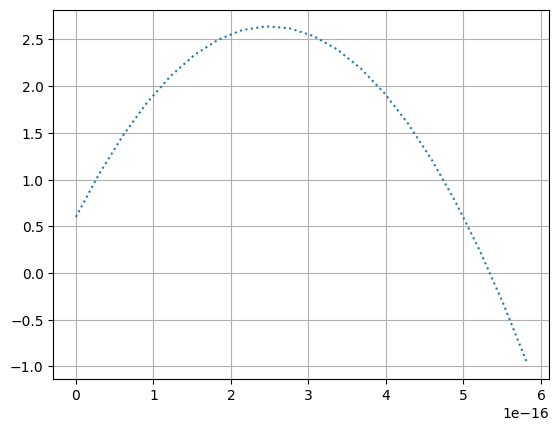

In [117]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(x,y, linestyle = 'dotted')
plt.grid()
plt.show()

7.5